## Import Libraries

In [1]:
import pickle
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier

import inspect

import xgboost as xgb
from mlxtend.evaluate import bootstrap
from numpy import format_float_scientific
from sklearn import preprocessing, svm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import (balanced_accuracy_score, classification_report,
                             confusion_matrix, f1_score, roc_auc_score,
                             roc_curve)
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, plot_tree

## Load Data

In [2]:
LOCATION = "../new_pressure_injury_data" 

dataset_name = {
    "main": "structured_data.pkl",
}["main"]

df = pd.read_pickle(os.path.join(LOCATION, dataset_name))

## Predictor Coding and Selection

In [35]:
df.PAT_SEX = df.PAT_SEX.replace({"Indeterminate": 0, "Male": 0, "Female": 1})
df.BMI = df.BMI.replace({"obesity": 3, "overweight": 2, "healthy weight": 1, "underweight": 0, "unknown": None})

## Plot Missingness

<AxesSubplot:ylabel='DE_ID_PAT_ID-ENCOUNTER_COUNTER'>

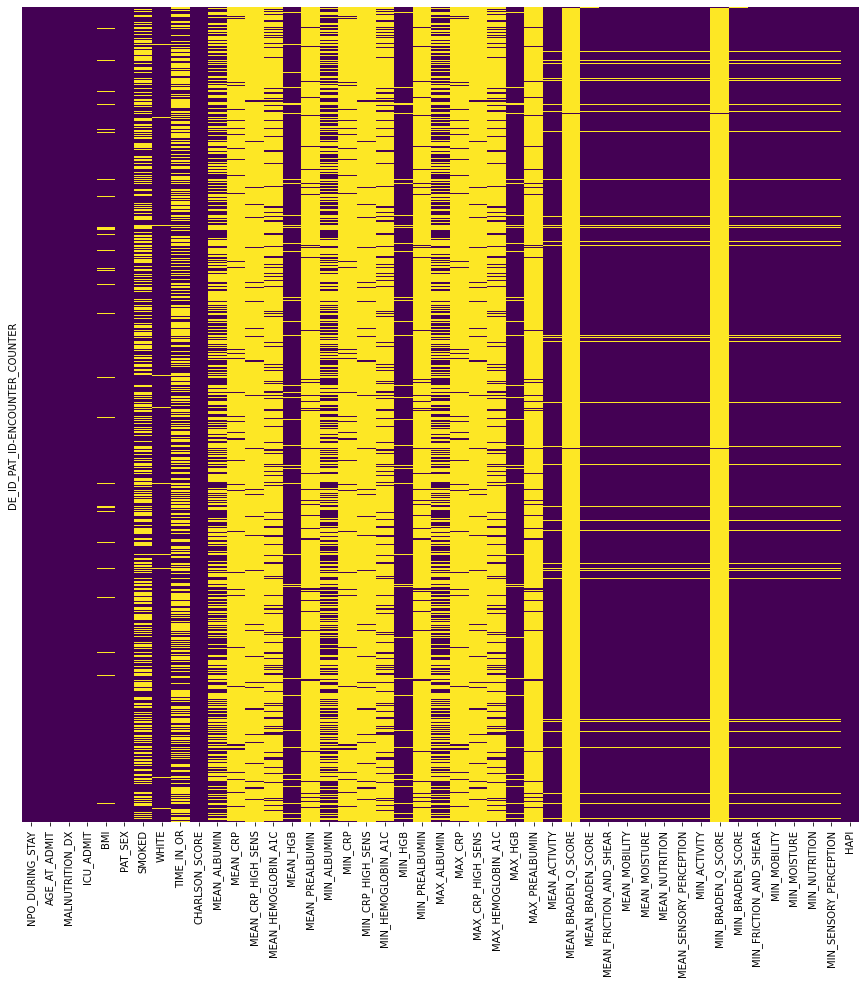

In [5]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Split Data into Training/Validation

In [36]:
X, y = df.drop(columns=['HAPI']), df['HAPI']

id_index = X.index.get_level_values('DE_ID_PAT_ID')

gss = GroupShuffleSplit(n_splits = 1, random_state=2)
gss.get_n_splits()
for train_idx, test_idx in gss.split(X, y, id_index):
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y.values, random_state=42)

## Imputation

In [38]:
basic = [
    'NPO_DURING_STAY',
    'AGE_AT_ADMIT',
    'MALNUTRITION_DX',
    'ICU_ADMIT',
    'BMI',
    'PAT_SEX',
    'SMOKED',
    'WHITE',
    'CHARLSON_SCORE'
]

imputer = IterativeImputer(sample_posterior=True).fit(X_train[basic].values)

X_train_imputed = pd.DataFrame(imputer.transform(X_train[basic].values), columns=basic, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[basic].values), columns=basic, index=X_test.index)

X_train = X_train_imputed.join(X_train.drop(basic, axis=1))
X_test = X_test_imputed.join(X_test.drop(basic, axis=1))

# fill with mean for rest of nan (mostly lab_data)
stopgap_impute_with_mean = [k for k, v in X_train.isna().sum().items() if v]

for header in stopgap_impute_with_mean:
    # fill with averages
    X_train[header] = X_train[header].fillna(np.mean(X_train[header]))#fillna(df.mean(), inplace=True)
    
    # also fill will X_train averages
    X_test[header] = X_test[header].fillna(np.mean(X_train[header]))#fillna(df.mean(), inplace=True)

# Main Functions
- Grid search (did bulk of search in other repositories and added ideal search parameters here)  
- SHAP  
- Bootstrapped AUC 
- Sensitivity Analysis  
- Additional plotting of ROC and SHAP per patient

In [40]:
def perform_grid_search(estimator, options, param_grid, no_grid, X_train, X_test, y_train, y_test, return_probs=True):
    if 'random_state' in inspect.signature(estimator).parameters.keys():
        options['random_state']=42
    if not no_grid:
        grid_search = GridSearchCV(estimator=estimator(**options), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
        grid_search.fit(X_train,y_train)
        best_params=grid_search.best_params_
    else:
        best_params=options
    options.update(best_params)
    best_estimator=estimator(**options)
    best_estimator.fit(X_train,y_train)
    y_pred=best_estimator.predict(X_test)
    if 'predict_proba' in dir(best_estimator) and return_probs:
        y_pred_probs=best_estimator.predict_proba(X_test)[:,1]
    else:
        y_pred_probs = y_pred
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
    roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
    results=pd.DataFrame(np.vstack([y_test.values,y_pred,y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])
    return best_estimator, roc_df, results
    
    
def extract_ys(Y):
    return Y[:,0], Y[:,1]

def auc(Y):
    y_true, y_pred=extract_ys(Y)
    return roc_auc_score(y_true, y_pred)

def return_bootstrap_results(results,fn,round_place=1):
    Y=results[['y_true','y_pred_probs']].values
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    std_err=format_float_scientific(std_err,round_place)
    if float(std_err) >= 0.001:
        std_err=float(std_err)
    
    return "{}±{}".format(float(format_float_scientific(original,round_place)),2*std_err)
    
def plot_roc(roc_df, results):
    plt.figure()
    ax=sns.lineplot('1-Specificity','Sensitivity',data=roc_df)
    plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))#roc_auc_score(results['y_true'], results['y_pred_probs']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
    
def plot_rocs(roc_dict):
    for k in roc_dict:
        roc_dict[k]['Method']=k
    df=pd.concat(list(roc_dict.values()))
    df=df.pivot_table(index="1-Specificity",columns="Method", values="Sensitivity")
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(10,10))
    plt.plot([0,1],[0,1],'--')
    # sns.lineplot('1-Specificity', 'Sensitivity', hue='Method', data=df)
    sns.lineplot(data=df, dashes=False)


## Return Estimators  
- Logistic Regression  
- Naive Bayes  
- Decision Trees  
- XGBoost  

In [41]:
best_estimator_lr, roc_df_lr, results_lr= perform_grid_search(LogisticRegression, 
                    options={'class_weight':'balanced','penalty': 'none', 'solver':'lbfgs'}, 
                    param_grid={'C':[np.inf]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)


In [42]:
best_estimator_nb, roc_df_nb, results_nb= perform_grid_search(GaussianNB, 
                    options={}, 
                    param_grid={}, 
                    no_grid=True, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)

In [43]:
best_estimator_dt, roc_df_dt, results_dt= perform_grid_search(DecisionTreeClassifier, 
                    options={'class_weight':'balanced','max_features':24}, 
                    param_grid={'max_depth':[20],
                               'min_samples_split':[0.6],
                               'min_samples_leaf':[0.4]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test,
                    return_probs=True)


In [44]:
best_estimator_xg, roc_df_xg, results_xg= perform_grid_search(XGBClassifier, 
                    options={'scale_pos_weight' : 56986/241, 'objective' : 'binary:logistic', 'eval_metric': 'error'}, 
                    param_grid={'learning_rate': [0.1],
                                'n_estimators': [100],
                                'max_depth': list(range(2,10,2)),
                                'min_child_weight':list(range(1,6,2))}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)

In [45]:
print("lr")
print(pd.crosstab(results_lr.y_true, results_lr.y_pred))

print("\nxg")
print(pd.crosstab(results_xg.y_true, results_xg.y_pred))

print("\ndt")
print(pd.crosstab(results_dt.y_true, results_dt.y_pred))

print("\nnb")
print(pd.crosstab(results_nb.y_true, results_nb.y_pred))

lr
y_pred    0.0   1.0
y_true             
0.0     21189  4353
1.0        13    38

xg
y_pred    0.0   1.0
y_true             
0.0     23922  1620
1.0        22    29

dt
y_pred    0.0    1.0
y_true              
0.0     15022  10520
1.0         5     46

nb
y_pred    0.0   1.0
y_true             
0.0     22879  2663
1.0        19    32


## Plot ROCs

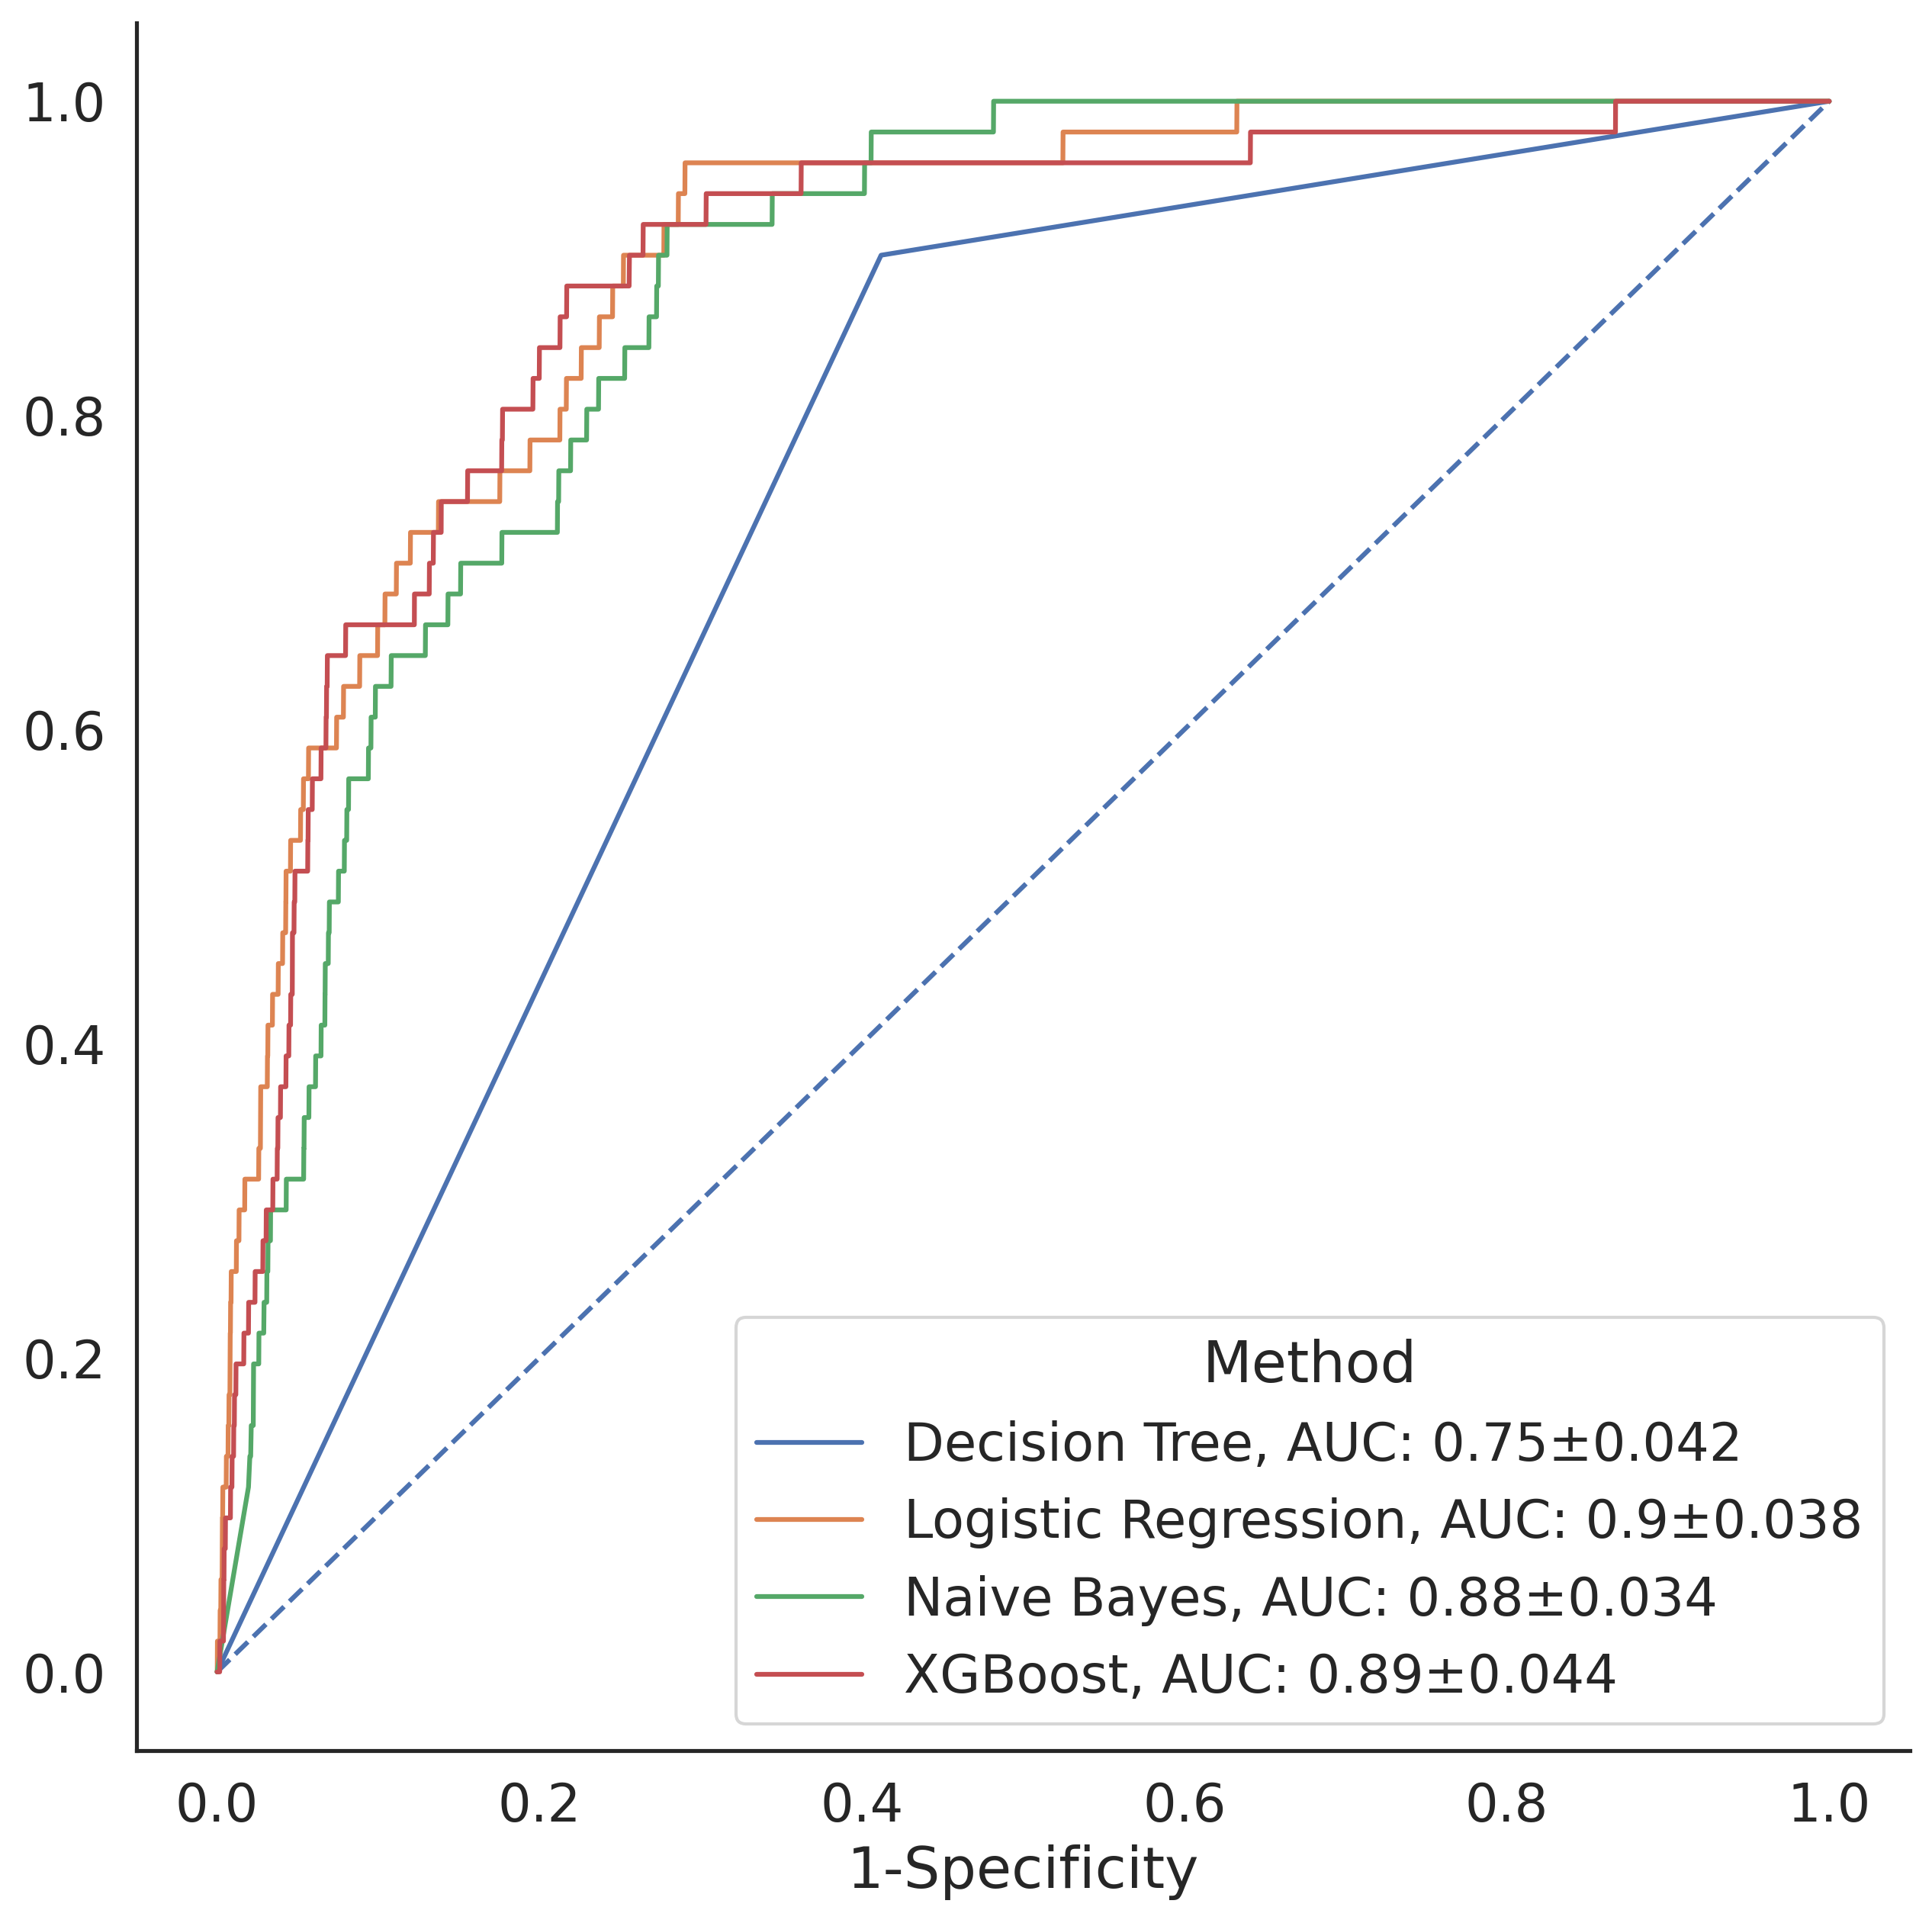

In [47]:
import matplotlib
matplotlib.rcParams['figure.dpi']=400
sns.set(style='white', font_scale=1.5)
np.random.seed(123)

roc_dict={
    f'Logistic Regression, AUC: {return_bootstrap_results(results_lr,auc,1)}':roc_df_lr,
    f'Decision Tree, AUC: {return_bootstrap_results(results_dt,auc,1)}': roc_df_dt,
    f'Naive Bayes, AUC: {return_bootstrap_results(results_nb,auc,1)}': roc_df_nb,
    f'XGBoost, AUC: {return_bootstrap_results(results_xg,auc,1)}': roc_df_xg
} 

plot_rocs(roc_dict)
plt.savefig(fname="aucs.png")
sns.despine()